In [4]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Datos simulados del LOB
np.random.seed(42)
n = 100  # Número de observaciones
true_price = np.cumsum(np.random.normal(0, 0.5, n)) + 100  # Precio real
mid_price = true_price + np.random.normal(0, 0.3, n)     # Mid-price observado
spread = 0.5  # Spread típico
best_bid = mid_price - spread / 2  # Precio bid
best_ask = mid_price + spread / 2  # Precio ask
bid_volume = np.random.poisson(50, n)  # Volumen bid
ask_volume = np.random.poisson(50, n)  # Volumen ask
volume_diff = bid_volume - ask_volume  # Diferencia de volúmenes

# DataFrame
df = pd.DataFrame({
    'mid_price': mid_price,
    'best_bid': best_bid,
    'best_ask': best_ask,
    'bid_volume': bid_volume,
    'ask_volume': ask_volume,
    'volume_diff': volume_diff
})


In [5]:
print(mid_price)
print(df.head())

[ 99.82374585 100.05303133 100.40025484 101.02390094 101.09912172
 101.15165421 102.38590114 102.25613607 102.04629065 102.21797178
 101.43296535 101.76777767 101.91478203 101.67904548 100.01990564
  99.88693437  99.27964108  99.09657486  99.33601308  98.5125943
  99.25714835  98.63413438  99.36155302  97.80778531  98.13220639
  98.66874725  97.13895288  97.45407346  97.35353885  97.02675387
  96.41174423  97.82365124  97.47764262  97.409556    97.40292346
  97.53330922  96.93778471  96.09630718  95.77288778  95.25800394
  96.0647345   96.47432349  95.54211155  95.92919483  95.21250852
  95.00916844  94.17321698  94.67672632  95.40125492  94.45224777
  94.60034221  94.43658768  93.7901848   94.36970647  94.90345186
  95.06686475  95.42129377  94.8491051   94.5151959   95.55732559
  94.82836789  95.26406828  94.82235409  93.63046741  94.57194785
  95.08488931  95.17166801  95.99585431  95.53401799  95.0589537
  95.19891802  95.99004755  96.1937471   97.10154504  95.77233413
  96.3484331

In [6]:
# Matriz de transición (4x4)
transition_matrix = np.array([
    [1, 1, 0, 0],  # p_t = p_{t-1} + v_{t-1}
    [0, 1, 0, 0],  # v_t = v_{t-1}
    [0, 0, 1, 1],  # d_t = d_{t-1} + s_{t-1}
    [0, 0, 0, 1]   # s_t = s_{t-1}
])

# Matriz de observación (2x4)
observation_matrix = np.array([
    [1, 0, 0, 0],  # Observamos p_t
    [0, 0, 1, 0]   # Observamos d_t
])

# Covarianzas
transition_covariance = 0.01 * np.eye(4)  # Q
observation_covariance = np.diag([0.1, 10])  # R (ruido en mid_price y volume_diff)

# Estado inicial
initial_state_mean = [mid_price[0], 0, volume_diff[0], 0]
initial_state_covariance = np.eye(4)

# Crear el filtro
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance
)


In [7]:
# Datos de observación: mid_price y volume_diff
observations = df[['mid_price', 'volume_diff']].values

# Filtrar
states, _ = kf.filter(observations)

# Guardar resultados
df['estimated_price'] = states[:, 0]
df['estimated_trend'] = states[:, 1]
df['estimated_volume_diff'] = states[:, 2]
df['estimated_volume_trend'] = states[:, 3]


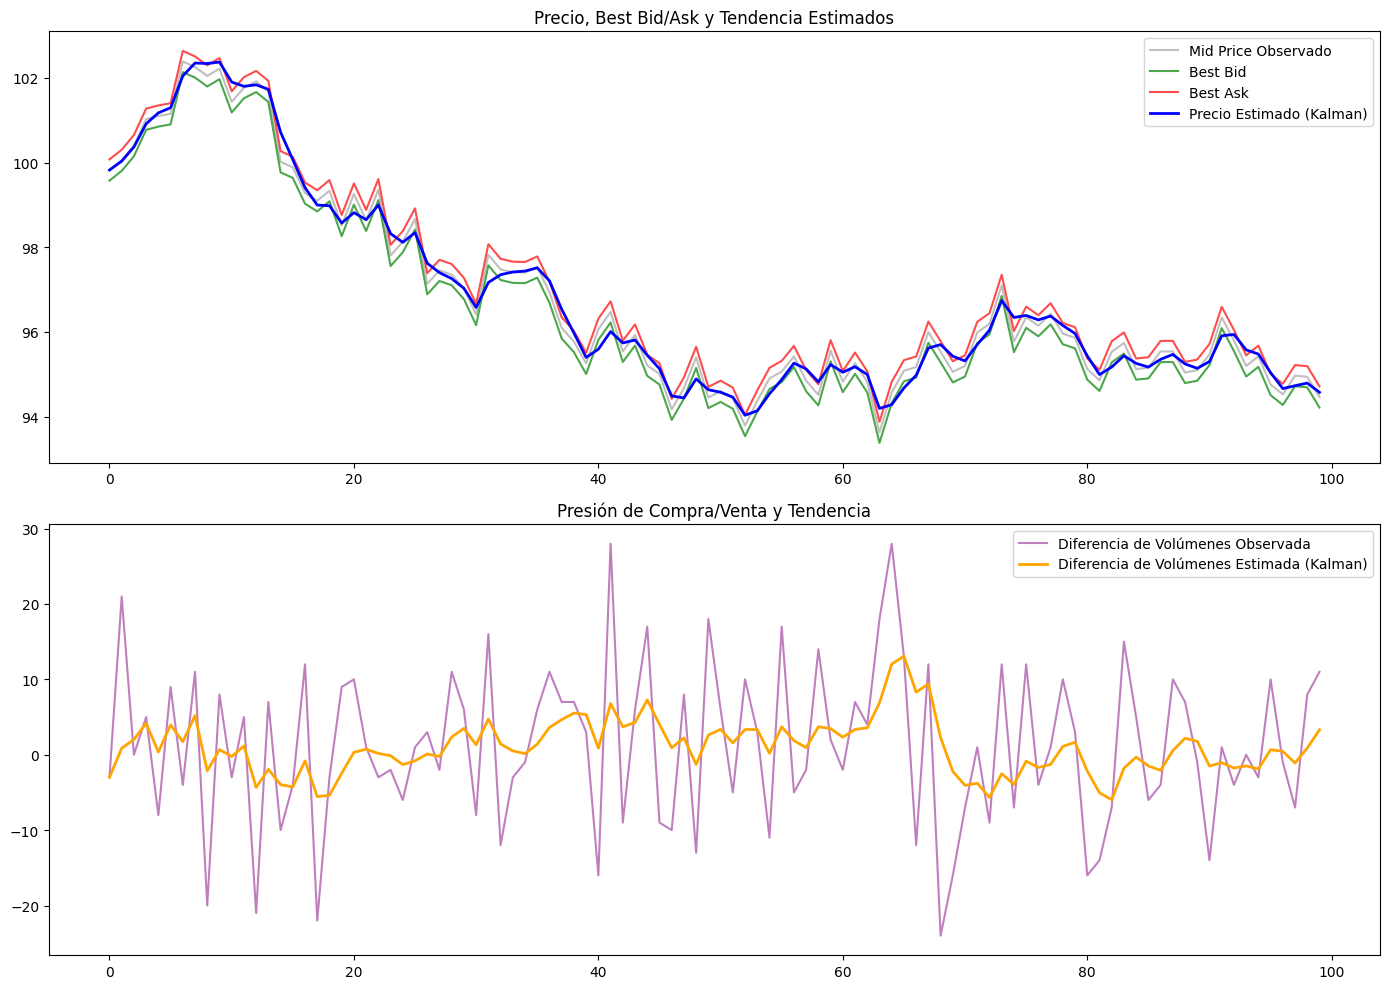

In [8]:
plt.figure(figsize=(14, 10))

# Gráfica del precio (mid_price, best bid, best ask y precio estimado)
plt.subplot(2, 1, 1)
plt.plot(df['mid_price'], label='Mid Price Observado', alpha=0.5, color='gray')
plt.plot(df['best_bid'], label='Best Bid', alpha=0.7, color='green')
plt.plot(df['best_ask'], label='Best Ask', alpha=0.7, color='red')
plt.plot(df['estimated_price'], label='Precio Estimado (Kalman)', linewidth=2, color='blue')
plt.legend()
plt.title('Precio, Best Bid/Ask y Tendencia Estimados')

# Gráfica de la diferencia de volúmenes
plt.subplot(2, 1, 2)
plt.plot(df['volume_diff'], label='Diferencia de Volúmenes Observada', alpha=0.5, color='purple')
plt.plot(df['estimated_volume_diff'], label='Diferencia de Volúmenes Estimada (Kalman)', linewidth=2, color='orange')
plt.legend()
plt.title('Presión de Compra/Venta y Tendencia')

plt.tight_layout()
plt.show()
